# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


## Project Overview

A mail order company that sells organic products in Germany is facing difficulty in determining which segments of the general population would most likely become customers should they be the targets of advertising by the company. The company can’t simply reach out to everyone in Germany as a potential customer as that would require a great expense and would consume a lot of the company’s resources.

Arvato Financial Solutions, a Bertelsmann subsidiary is trying to figure out which people in Germany are most likely new customers for their client, the mail order company. This project finds a solution to improve efficiency in the customer acquisition process. Using Machine learning and data analysis, we can identify potential customers and that would allow the company to do targeted advertising.

Targeted advertising is based on the traits and behavioral patterns of different people. These traits can be demographic such as economic status, age or generation, the level of education, employment and income level. Or they can be psychographic such as personality, attitude, lifestyle and interests.

Traditional targeted advertising worked by manually creating a set of rules that influenced whether an individual would become a target for advertising or not. AI however allows us to find relationships between certain attributes and potential customers that we didn’t know existed, and sometimes it might not be directly interpretable. Today, many brands are beginning to use artificial intelligence to identify and segment audiences allowing them to identify potential customers. In this project, we will be using machine learning techniques to achieve that goal.



## Project Workflow

1. Clean the data by dropping outliers in terms of missing data, remove unwanted features and re-engineering mixed features.
2. Impute missing data with appropriate values that represent the data and apply feature scaling
3. Reduce the size of the data using a dimensionality reduction technique
4. use unsupervised learning (K-means clustering) to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company.
5. apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company.
6. account for class imbalance if it exists and compare the results of several different supervised learning algorithms to predict which individuals are most likely to convert into becoming customers for the company.


## Solution Statement

we will use unsupervised learning techniques to analyze the data and find relationships between demographics information of the general population and demographics information of the company's customers. We will then apply what we have learned on a third dataset to try and predict which individuals are more likely to become customers for the company.


## Model Evaluation

for the model evaluation, we must consider both recall and precision. usually improving precision comes at the cost of recall and vice versa, which is why we are going to use ROC (Receiver Operating Characteristics) AUC (Area Under the Curve) as our metric. ROC AUC measures the overall performance of the classifier. it is also the metric used to determine the performance of a classifier in the kaggle competition.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, roc_auc_score, make_scorer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_model import BinaryClassifier
from model_utils import train_model, visualize_results

# magic word for producing visualizations in notebook
%matplotlib inline

## Data Exploration

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('azdias.csv')
azdias.drop('Unnamed: 0', axis = 1, inplace = True)
customers = pd.read_csv('customers.csv')
customers.drop('Unnamed: 0', axis = 1, inplace = True)

C:\Users\Mahmo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_original = azdias.copy(deep = True)

In [4]:
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [5]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


By reading the Attributes file we are able to find values that indicate missing data for each column in the dataset, we can then reference these values to replace missing values with np.nan

In [7]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1)
feat_info.drop('Unnamed: 0', axis = 1, inplace = True)
feat_info.dropna(inplace = True)
feat_info = feat_info[feat_info['Meaning'].str.contains('unknown') | feat_info['Meaning'].str.contains('no')]

## 1: Data Preprocessing

### 1.1: Assess Missing Data

The DIAS Attributes file contains a summary of properties for each demographics data column. I will use this file along with the DIAS information levels file to help in cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data.

#### 1.1.1: Convert Missing Value Codes to NaNs
The third column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. The file encodes this as either a single integer if there is only one indication for missing values, or a string containing several missing value indicators. I will need to do a little bit of parsing to make use of it to identify and convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [8]:
print(feat_info.shape)
feat_info.head(20)

(279, 4)


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known


In [9]:
def find_missings(data):
    print('known missings: ', data.isna().sum().sum())
    for attribute, missing_value_indicators in list(zip(feat_info.Attribute, feat_info.Value)):
        if attribute not in azdias.columns:
            continue
        if(type(missing_value_indicators) == str):
            missing_value_indicators = missing_value_indicators.split(',')
        elif(type(missing_value_indicators == int)):
            missing_value_indicators = [missing_value_indicators]
        else:
            print('unexpected value')
        
        for i in range(len(missing_value_indicators)):
            try:
                missing_value_indicators[i] = int(missing_value_indicators[i])
            except ValueError:
                pass  

        for ind in missing_value_indicators:
            data[attribute].replace(ind, np.nan, inplace = True)

    print('total missings: ', data.isna().sum().sum())

In [10]:
find_missings(azdias)
azdias.head(5)

known missings:  33492923
total missings:  45737847


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing.I will use Matplotlib to visualize the distribution of missing value counts to find these columns.

In [11]:
def count_missings(data, axis):
    return data.isna().sum(axis = axis)

In [12]:
column_missings = count_missings(azdias, 0)
lst = list(range(len(column_missings)))

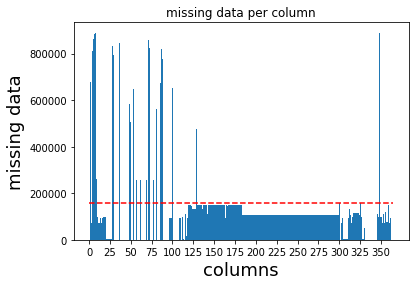

<Figure size 698.4x482.4 with 0 Axes>

In [13]:
# Investigating patterns in the amount of missing data in each column.
plt.hist(lst, bins = 366, weights = column_missings)
plt.xticks(range(0,370,25))
plt.yticks(range(0,2000000,200000))
plt.xlabel('columns', fontsize = 18)
plt.ylabel('missing data', fontsize = 18)
plt.title('missing data per column')
horiz_line_data = np.array([160000 for i in lst])
plt.plot(horiz_line_data, 'r--')
plt.figure(figsize=(9.7,6.7))
plt.show()

In [14]:
original_columns_list = list(azdias.columns)
drop_list_indices = []
print('dropped columns: \n')
for ind,missings in enumerate(column_missings):
    if missings>160000:
        print(azdias.columns[ind],' contains ', missings, ' missing values')
        drop_list_indices.append(ind)

dropped_columns_names = list(azdias.columns[drop_list_indices])
high_missing_columns = dropped_columns_names.copy()
azdias.drop(azdias.columns[drop_list_indices], axis = 1, inplace = True)

dropped columns: 

AGER_TYP  contains  677503  missing values
ALTER_HH  contains  310267  missing values
ALTER_KIND1  contains  810163  missing values
ALTER_KIND2  contains  861722  missing values
ALTER_KIND3  contains  885051  missing values
ALTER_KIND4  contains  890016  missing values
ALTERSKATEGORIE_FEIN  contains  262947  missing values
D19_BANKEN_ANZ_12  contains  831734  missing values
D19_BANKEN_ANZ_24  contains  794100  missing values
D19_BANKEN_ONLINE_QUOTE_12  contains  845987  missing values
D19_GESAMT_ANZ_12  contains  584797  missing values
D19_GESAMT_ANZ_24  contains  505303  missing values
D19_GESAMT_ONLINE_QUOTE_12  contains  650188  missing values
D19_KONSUMTYP  contains  257113  missing values
D19_LETZTER_KAUF_BRANCHE  contains  257113  missing values
D19_LOTTO  contains  257113  missing values
D19_SOZIALES  contains  257113  missing values
D19_TELKO_ANZ_12  contains  857990  missing values
D19_TELKO_ANZ_24  contains  826208  missing values
D19_TELKO_ONLINE_QUOTE_12 

In [15]:
print(azdias.shape)
print(feat_info.shape)

(891221, 336)
(279, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

As shown in the histrogram above, columns that have missing values exceeding the 160,000 threshold are clear outliers and were removed from the dataset

some of the removed columns were not described in the Attributes or the information levels files.
information about the removed columns include:

1. Best-ager typology
2. Main age within the household
3. Transaction activity in banks within different periods of time
4. Transaction activity in Insurance within different periods of time
5. flag whether this person holds an academic title

The other columns with low number of missing data seem to have a similar number of missing data for the most part, around 100,000 for each column. Many of these columns share the exact same rows of missing data with other columns. 

#### 1.1.3: Assess Missing Data in Each Row

Now, I will perform a similar assessment for the rows of the dataset to clarify how much data is missing in each row. As with the columns, we will see some groups of points that have a very different numbers of missing values. rows with high number of missing data will be removed for simplicity.

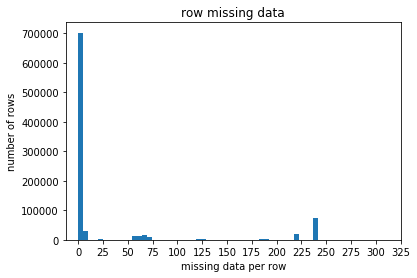

In [16]:
row_missings = count_missings(azdias, 1)
len(row_missings)

plt.hist(row_missings, bins = 50)
plt.xticks(range(0,350,25))

plt.xlabel('missing data per row')
plt.ylabel('number of rows')
plt.title('row missing data')
plt.show()

In [ ]:
high_missing_rows = []

for ind,missings in enumerate(row_missings):
    if missings>15:
        high_missing_rows.append(ind)
        
azdias.drop(high_missing_rows, axis = 0, inplace = True)

In [18]:
azdias.shape

(732895, 336)

### 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

#### 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we will perform one of the following:
- For binary (two-level) categoricals that take numeric values, we will keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [20]:
#before we re-encode categorical features I wanted to double check the set of unique values for each column since 
#the attributes and information levels files seems to not be 100% accurate
for variable in azdias.columns:
    print (variable, 'contains values: ', set(azdias[variable].dropna()))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ANZ_HAUSHALTE_AKTIV contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 

D19_VOLLSORTIMENT contains values:  {0, 1, 2, 3, 4, 5, 6, 7}
D19_WEIN_FEINKOST contains values:  {0, 1, 2, 3, 4, 5, 6, 7}
DSL_FLAG contains values:  {0.0, 1.0}
EINGEFUEGT_AM contains values:  {'1994-03-25 00:00:00', '2001-12-28 00:00:00', '1997-04-14 00:00:00', '1997-01-08 00:00:00', '1994-08-10 00:00:00', '2002-11-05 00:00:00', '1997-02-25 00:00:00', '1993-11-09 00:00:00', '2005-04-14 00:00:00', '1993-04-01 00:00:00', '2002-08-05 00:00:00', '2001-03-15 00:00:00', '2001-01-05 00:00:00', '1994-01-24 00:00:00', '1999-07-07 00:00:00', '1996-01-30 00:00:00', '1997-03-20 00:00:00', '1999-03-29 00:00:00', '1999-08-10 00:00:00', '1995-06-07 00:00:00', '2003-08-29 00:00:00', '2000-08-11 00:00:00', '2000-05-19 00:00:00', '2000-12-05 00:00:00', '2001-02-23 00:00:00', '2004-04-17 00:00:00', '2001-04-12 00:00:00', '2005-03-24 00:00:00', '2002-10-15 00:00:00', '2004-06-05 00:00:00', '2005-02-03 00:00:00', '2004-03-11 00:00:00', '2004-10-10 00:00:00', '2005-01-03 00:00:00', '1998-02-07 00:00:00', '1

EINGEZOGENAM_HH_JAHR contains values:  {1971.0, 1984.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 1900.0, 1904.0}
EWDICHTE contains values:  {1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
FINANZ_ANLEGER contains values:  {1, 2, 3, 4, 5}
FINANZ_HAUSBAUER contains values:  {1, 2, 3, 4, 5}
FINANZ_MINIMALIST contains values:  {1, 2, 3, 4, 5}
FINANZ_SPARER contains values:  {1, 2, 3, 4, 5}
FINANZ_UNAUFFAELLIGER contains values:  {1, 2, 3, 4, 5}
FINANZ_VORSORGER contains values:  {1, 2, 3, 4, 5}
FINANZTYP contains values:  {1, 2, 3, 4, 5, 6}
FIRMENDICHTE contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
GEBAEUDETYP contains values:  {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0}
GEBAEUDETYP_RASTER contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
GEBURTSJAHR contains values:  {0, 1900, 1904, 1905, 1906, 1907, 19

KBA13_AUTOQUOTE contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BAUMAX contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_1999 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_2000 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_2004 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_2006 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_2008 contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BJ_2009 contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_BMW contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_0_1400 contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1000 contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1200 contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1400 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1401_2500 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1500 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1600 contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
KBA13_CCM_1800 contains values:  {0.

RELAT_AB contains values:  {1.0, 2.0, 3.0, 4.0, 5.0, 9.0}
RETOURTYP_BK_S contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
RT_KEIN_ANREIZ contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
RT_SCHNAEPPCHEN contains values:  {1.0, 2.0, 3.0, 4.0, 5.0}
RT_UEBERGROESSE contains values:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
SEMIO_DOM contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_ERL contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_FAM contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_KAEM contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_KRIT contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_KULT contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_LUST contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_MAT contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_PFLICHT contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_RAT contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_REL contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_SOZ contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_TRADV contains values:  {1, 2, 3, 4, 5, 6, 7}
SEMIO_VERT contains values:  {1, 2, 3, 

variable CAMEO_INTL_2015 had numerical values and an 'XX' value, which we could assume refers to missing data. since i didn't find any information on this variable in the Attributes or information levels files, i decided to drop it.

variable EINGEFUEGT_AM contains dates with thousands of unique values and can be safely dropped as it doesn't provide valuable information.

for variable OST_WEST_KZ we will re-encode the 'O' and 'W' into numerical binary 0 and 1

for variable CAMEO_DEUG_2015 the attributes file shows that missing values are indicated with -1 however our set of unique values for this variable shows that missing values are indicated with 'X', so we can replace that with np.nan, also some values that were supposed to be integer were input as strings so we will replace those with their integer counterpart.

In [21]:
azdias.drop(['CAMEO_INTL_2015', 'EINGEFUEGT_AM'], axis = 1, inplace = True)
dropped_columns_names.extend(['CAMEO_INTL_2015', 'EINGEFUEGT_AM'])

azdias['OST_WEST_KZ'].replace('W', 1, inplace = True)
azdias['OST_WEST_KZ'].replace('O', 0, inplace = True)

str_lst = ['1','2','3','4','5','6','7','8','9']

azdias['CAMEO_DEUG_2015'].replace('X', np.nan, inplace = True)

for val in str_lst:
    azdias['CAMEO_DEUG_2015'].replace(val, int(val), inplace = True)

In [22]:
#in the attribute GEBAEUDETYP, value 5 is reserved for a single row. since we are going to one hot encode that variable
azdias['GEBAEUDETYP'].value_counts()

1.0    419634
3.0    162180
8.0    145435
2.0      4258
4.0       829
6.0       558
5.0         1
Name: GEBAEUDETYP, dtype: int64

In [23]:
# we want to avoid creating an extra column that doesn't provide us with information by dropping the row with value 5
idx = azdias.index[azdias['GEBAEUDETYP'] == 5].tolist()
azdias.drop(idx, axis = 0, inplace = True)

In [24]:
#since the Attributes file doesn't describe the type of data for each column, I had to manually check the value associated
#with each column to determine which variables are considered categorical and which contain mixed features. as I manually
#checked the values for each column, the following list may not be 100% accurate.

categorical_variables = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG','CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'HAUSHALTSSTRUKTUR', 
                         'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 
                         'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_FEI', 
                         'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 
                         'LP_STATUS_GROB''NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']

In [25]:
#this cell shows the number of unique values in each of the categorical variables above
for variable in categorical_variables:
    try:
        l = len(set(azdias[variable].dropna()))
    except:
        l = None
    print(variable, 'contains values: ', l)

AGER_TYP contains values:  None
ANREDE_KZ contains values:  2
BIP_FLAG contains values:  None
CAMEO_DEUG_2015 contains values:  9
CAMEO_DEU_2015 contains values:  45
HAUSHALTSSTRUKTUR contains values:  None
CAMEO_DEUINTL_2015 contains values:  None
CJT_GESAMTTYP contains values:  6
D19_KONSUMTYP contains values:  None
FINANZTYP contains values:  6
GEBAEUDETYP contains values:  6
GEBAEUDETYP_RASTER contains values:  5
GFK_URLAUBERTYP contains values:  12
HEALTH_TYP contains values:  3
KBA05_MAXHERST contains values:  5
LP_FAMILIE_FEI contains values:  None
LP_FAMILIE_GROB contains values:  6
LP_LEBENSPHASE_FEIN contains values:  41
LP_LEBENSPHASE_GROB contains values:  13
LP_STATUS_FEIN contains values:  10
LP_STATUS_GROBNATIONALITAET_KZ contains values:  None
SHOPPER_TYP contains values:  4
TITEL_KZ contains values:  None
VERS_TYP contains values:  2
ZABEOTYP contains values:  6


In [26]:
#dropping multi-categorical variables that contain more than 7 unique values for simplicity, and since one hot encoding 
#those variables could potentially double the size of the dataset

for variable in categorical_variables:
    if variable in azdias.columns:
        number_of_unique_values = len(set(azdias[variable].dropna()))
        if number_of_unique_values > 9:
            azdias.drop(variable, axis = 1, inplace = True)
            dropped_columns_names.append(variable)
            print(variable, 'with unique values count: ', number_of_unique_values, ' has been dropped')
            
        else:
            dummies = pd.get_dummies(azdias[variable])
            azdias.drop(variable, axis = 1, inplace = True)
            
            dropped_columns_names.append(variable)
            ## this is to ensure no duplicate names for multiple dummy variables created for different attributes
            dummies_names = list(dummies.columns)
            for i, col in enumerate(dummies_names):
                dummies_names[i] = variable+str(col)
                
            dummies.columns = dummies_names
            ##
            azdias = pd.concat([azdias, dummies], axis = 1)
            print(variable, ' has been one hot encoded')
            
            
    else:
        print(variable, ' not found in azdias')

AGER_TYP  not found in azdias
ANREDE_KZ  has been one hot encoded
BIP_FLAG  not found in azdias
CAMEO_DEUG_2015  has been one hot encoded
CAMEO_DEU_2015 with unique values count:  45  has been dropped
HAUSHALTSSTRUKTUR  not found in azdias
CAMEO_DEUINTL_2015  not found in azdias
CJT_GESAMTTYP  has been one hot encoded
D19_KONSUMTYP  not found in azdias
FINANZTYP  has been one hot encoded
GEBAEUDETYP  has been one hot encoded
GEBAEUDETYP_RASTER  has been one hot encoded
GFK_URLAUBERTYP with unique values count:  12  has been dropped
HEALTH_TYP  has been one hot encoded
KBA05_MAXHERST  has been one hot encoded
LP_FAMILIE_FEI  not found in azdias
LP_FAMILIE_GROB  has been one hot encoded
LP_LEBENSPHASE_FEIN with unique values count:  41  has been dropped
LP_LEBENSPHASE_GROB with unique values count:  13  has been dropped
LP_STATUS_FEIN with unique values count:  10  has been dropped
LP_STATUS_GROBNATIONALITAET_KZ  not found in azdias
SHOPPER_TYP  has been one hot encoded
TITEL_KZ  not fou

#### Discussion 1.2.1: Re-Encode Categorical Features

the column 'OST_WEST_KZ' was encoded into 1s and 0s instead of 'W' and 'O', and the multi-level categoricals were dropped entirely to keep things straightforward. had i decided to use dummy variables for these categorical data columns, it would have resulted in about 140 added columns, essentially increasing the size of our data by about 50% only to account for very few columns.

#### 1.2.2: Engineer Mixed-Type Features

the variable "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

In [27]:
# Investigating "PRAEGENDE_JUGENDJAHRE" and engineering two new variables.

decade = []
movement = []

info = """-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)"""

info = info.replace(' ','').replace('\n','').replace('-','').split(')')
    
    
for val in azdias['PRAEGENDE_JUGENDJAHRE']:
    if pd.isna(val):
        decade.append(np.nan)
        movement.append(np.nan)
        continue
        
    i = int(val - 1)
    colon_ind = info[i].index(':')
    bracket_ind = info[i].index('(')
    comma_ind = info[i].index(',')
    
    dec = info[i][colon_ind+1:colon_ind+3]
    mov = info[i][bracket_ind + 1:comma_ind]
    
    decade.append(int(dec))
    if mov == 'Mainstream':
        movement.append(0)
    else:
        movement.append(1)

In [28]:
azdias['decade'] = decade
azdias['movement'] = movement
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
dropped_columns_names.append('PRAEGENDE_JUGENDJAHRE')
azdias.shape

(732894, 378)

In [29]:
print(set(azdias['decade'].dropna()))
print(set(azdias['movement'].dropna()))

{70.0, 40.0, 80.0, 50.0, 90.0, 60.0}
{0.0, 1.0}


In [30]:
azdias.shape

(732894, 378)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Through clever indexing, i was able to extract the information from the "PRAEGENDE_JUGENDJAHRE" column into two new columns "decade" and "movement". the missing values are accounted for in the new columns.

The new columns are added to the original data set, while the old column "PRAEGENDE_JUGENDJAHRE" was dropped from it as it no longer has value.

#### 1.2.3: Analysing Feature Correlation

while I was observing the information levels excel sheet, i noticed that many of the attributes share a similar meaning, or contain data related to one thing. so for example: some of the D19 attributes discuss actuality of last transactions under different conditions. The idea here is if i found many features having high correlation between each other i could safely drop most of those features. I decided to check the correlation between some of these variables, since checking the correlation between all the columns in the dataset would be very difficult to interpret because the dataset has 372 columns, so I picked some related attributes and showed their correlation matrix in the following code.

In [31]:
#checking correlation between variables
correlation_features = """D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERSI_DATUM
"""
correlation_features_original = correlation_features.split()
correlation_features = correlation_features_original.copy()

for variable in correlation_features_original:
    if variable not in azdias.columns:
        correlation_features.remove(variable)
        
print(correlation_features)

['D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']


In [32]:
corr_matrix = azdias[correlation_features].corr().abs().round(2)
display(corr_matrix)

,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_DATUM
D19_GESAMT_OFFLINE_DATUM,1.00,0.41,0.55,0.31,0.20,0.29,0.38,0.04,0.32,0.80,0.40,0.52,0.25,0.05,0.25
D19_GESAMT_ONLINE_DATUM,0.41,1.00,0.88,0.12,0.47,0.49,0.19,0.08,0.34,0.36,0.94,0.91,0.13,0.10,0.35
D19_GESAMT_DATUM,0.55,0.88,1.00,0.15,0.42,0.48,0.24,0.07,0.42,0.46,0.83,0.87,0.15,0.09,0.51
D19_BANKEN_OFFLINE_DATUM,0.31,0.12,0.15,1.00,0.08,0.33,0.19,0.01,0.13,0.16,0.11,0.13,0.18,0.02,0.10
D19_BANKEN_ONLINE_DATUM,0.20,0.47,0.42,0.08,1.00,0.89,0.14,0.03,0.28,0.15,0.31,0.31,0.11,0.07,0.25
D19_BANKEN_DATUM,0.29,0.49,0.48,0.33,0.89,1.00,0.19,0.03,0.31,0.20,0.35,0.35,0.15,0.07,0.28
D19_TELKO_OFFLINE_DATUM,0.38,0.19,0.24,0.19,0.14,0.19,1.00,0.02,0.54,0.17,0.19,0.20,0.17,0.03,0.17
D19_TELKO_ONLINE_DATUM,0.04,0.08,0.07,0.01,0.03,0.03,0.02,1.00,0.17,0.04,0.05,0.05,0.01,0.01,0.03
D19_TELKO_DATUM,0.32,0.34,0.42,0.13,0.28,0.31,0.54,0.17,1.00,0.18,0.31,0.31,0.16,0.06,0.25
D19_VERSAND_OFFLINE_DATUM,0.80,0.36,0.46,0.16,0.15,0.20,0.17,0.04,0.18,1.00,0.36,0.52,0.11,0.03,0.18


#### Discussion 1.2.3: Analysing Feature Correlation

After comparing many sets of attributes there wasn't any obvious correlation between several variables so I decided to stick with using PCA later in the project without manually dropping attributes by looking at correlation matrix.

In [33]:
#to save some memory this object will be cleared as it is no longer needed
azdias = None

### 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, we will create a function to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data later in the project, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
dropped_columns_names = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM', 'ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'PRAEGENDE_JUGENDJAHRE']
high_missing_columns = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

In [35]:
def clean_data(data, feat_info, columns_to_drop, high_missing_columns):
    print('converting missing data to np.nan...\n')
    for attribute, missing_value_indicators in list(zip(feat_info.Attribute, feat_info.Value)):
        if attribute not in data.columns:
            continue
        if(type(missing_value_indicators) == str):
            missing_value_indicators = missing_value_indicators.split(',')
        elif(type(missing_value_indicators == int)):
            missing_value_indicators = [missing_value_indicators]
        else:
            print('unexpected value')
        
        for i in range(len(missing_value_indicators)):
            try:
                missing_value_indicators[i] = int(missing_value_indicators[i])
            except ValueError:
                pass  

        for ind in missing_value_indicators:
            data[attribute].replace(ind, np.nan, inplace = True)

    
    ##dropping the row with value 5 in GEBAEUDETYP
    idx = data.index[data['GEBAEUDETYP'] == 5].tolist()
    data.drop(idx, axis = 0, inplace = True)
    
    print('handing unique attributes: OST_WEST_KZ and CAMEO_DEUG_2015...\n')

    data['OST_WEST_KZ'].replace('W', 1, inplace = True)
    data['OST_WEST_KZ'].replace('O', 0, inplace = True)

    str_lst = ['1','2','3','4','5','6','7','8','9']

    data['CAMEO_DEUG_2015'].replace('X', np.nan, inplace = True)

    for val in str_lst:
        data['CAMEO_DEUG_2015'].replace(val, int(val), inplace = True)
        
    #handing categorical variables
    print('handling categorical variables...\n')
    categorical_variables = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG','CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'HAUSHALTSSTRUKTUR', 
                             'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 
                             'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_FEI', 
                             'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 
                             'LP_STATUS_GROB''NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']
    
    for variable in categorical_variables:
        if variable in data.columns and variable not in high_missing_columns:
            number_of_unique_values = len(set(data[variable].dropna()))
            if number_of_unique_values > 9:
                #print(variable, 'with unique values count: ', number_of_unique_values, ' has been dropped')
                pass
            else:
                dummies = pd.get_dummies(data[variable])
                
                #renaming dummies columns
                dummies_names = list(dummies.columns)
                for i, col in enumerate(dummies_names):
                    dummies_names[i] = variable+str(col)

                dummies.columns = dummies_names
                
                data = pd.concat([data, dummies], axis = 1)
                #print(variable, ' has been one hot encoded')
                

        else:
            #print(variable, ' not found in data or has been dropped previously')
            pass

    
    # Investigating "PRAEGENDE_JUGENDJAHRE" and engineering two new variables.
    print('engineering the variable PRAEGENDE_JUGENDJAHRE into two new variables...')

    decade = []
    movement = []

    info = """-  1: 40s - war years (Mainstream, E+W)
    -  2: 40s - reconstruction years (Avantgarde, E+W)
    -  3: 50s - economic miracle (Mainstream, E+W)
    -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    -  5: 60s - economic miracle (Mainstream, E+W)
    -  6: 60s - generation 68 / student protestors (Avantgarde, W)
    -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
    -  8: 70s - family orientation (Mainstream, E+W)
    -  9: 70s - peace movement (Avantgarde, E+W)
    - 10: 80s - Generation Golf (Mainstream, W)
    - 11: 80s - ecological awareness (Avantgarde, W)
    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    - 13: 80s - Swords into ploughshares (Avantgarde, E)
    - 14: 90s - digital media kids (Mainstream, E+W)
    - 15: 90s - ecological awareness (Avantgarde, E+W)"""

    info = info.replace(' ','').replace('\n','').replace('-','').split(')')


    for val in data['PRAEGENDE_JUGENDJAHRE']:
        if pd.isna(val):
            decade.append(np.nan)
            movement.append(np.nan)
            continue

        i = int(val - 1)
        colon_ind = info[i].index(':')
        bracket_ind = info[i].index('(')
        comma_ind = info[i].index(',')

        dec = info[i][colon_ind+1:colon_ind+3]
        mov = info[i][bracket_ind + 1:comma_ind]

        decade.append(int(dec))
        if mov == 'Mainstream':
            movement.append(0)
        else:
            movement.append(1)
            
    data['decade'] = decade
    data['movement'] = movement
    
    
    print('\ndropping columns with high number of missing values...')
    data.drop(columns_to_drop, axis = 1, inplace = True)
    
    #removing  rows with lots of missing data    
    print('\ndropping rows with high number of missing data...\n')
    row_missings = data.isna().sum(axis = 1)
    
    high_missing_rows = []
                
    for ind,missings in enumerate(row_missings):
        if missings>15:
            high_missing_rows.append(ind)


    data.drop(high_missing_rows, axis = 0, inplace = True)
    
    print(data.shape)
    
    return data

In [36]:
general_population = clean_data(azdias_original, feat_info, dropped_columns_names, high_missing_columns)

converting missing data to np.nan...

handing unique attributes: OST_WEST_KZ and CAMEO_DEUG_2015...

handling categorical variables...

engineering the variable PRAEGENDE_JUGENDJAHRE into two new variables...

dropping columns with high number of missing values...

dropping rows with high number of missing data...

(734903, 378)


## 2: Feature Transformation

### 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we have to make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. we might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, this will be discussed in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. we shouldn't forget to keep the fit sklearn objects handy, since we'll be applying them to the customer demographics data towards the end of the project.

In [37]:
general_population.shape

(734903, 378)

In [38]:
#calculation for number of rows that have no missing data
row_missings = general_population.isna().sum(axis = 1)
lst = list(row_missings)
lst.count(0)

# 567093 out of 734903 rows have no missing data (22.83% have missing data)

567093

In [39]:
#calculation for total number of missing data
general_population.isna().sum().sum()

# 546652 out of (734904*379) of the data is missing (0.19% of the total data is missing)

546652

In [40]:
imputer = SimpleImputer()
imputed_data = pd.DataFrame(imputer.fit_transform(general_population))
print(imputed_data.shape)
print('number of remining missing values in the whole data set: ',imputed_data.isna().sum().sum())
imputed_data.head()

general_population_columns = list(general_population.columns)
general_population = None

(734903, 378)
number of remining missing values in the whole data set:  0


In [41]:
imputed_data.shape

(734903, 378)

In [42]:
standarizer = StandardScaler()
standarized_data = pd.DataFrame(standarizer.fit_transform(imputed_data))
standarized_data.columns = general_population_columns
print(standarized_data.shape)
standarized_data.head()

(734903, 378)


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERS_TYP1.0,VERS_TYP2.0,ZABEOTYP1,ZABEOTYP2,ZABEOTYP3,ZABEOTYP4,ZABEOTYP5,ZABEOTYP6,decade,movement
0,1.057661,1.260589,0.186871,-0.125967,-0.299183,0.223920,0.335422,-0.060677,-0.179268,0.850325,...,-0.907516,0.996264,-0.427308,-0.192444,-0.740912,-0.597120,2.949950,-0.313677,1.173152,-0.554911
1,1.057681,1.260589,0.120667,-0.125967,-0.299183,-0.634999,-0.031933,-0.060677,-0.179268,-0.980900,...,1.101909,-1.003750,-0.427308,-0.192444,-0.740912,-0.597120,2.949950,-0.313677,1.173152,1.856332
2,1.057685,-0.935814,-0.475162,-0.125967,-0.299183,-1.493918,-0.399287,-0.060677,-1.185284,-0.065288,...,1.101909,-1.003750,-0.427308,-0.192444,1.349687,-0.597120,-0.338989,-0.313677,-0.216761,-0.554911
3,1.057743,-0.935814,-0.342756,-0.125967,-0.299183,1.941758,-0.325817,-0.060677,0.826747,-0.980900,...,-0.907516,0.996264,-0.427308,-0.192444,-0.740912,1.674704,-0.338989,-0.313677,-0.216761,-0.554911
4,1.057755,-0.935814,-0.210349,-0.125967,-0.299183,-0.634999,-0.399287,-0.060677,-1.185284,0.850325,...,-0.907516,0.996264,-0.427308,-0.192444,-0.740912,1.674704,-0.338989,-0.313677,-1.606674,-0.554911


### Discussion 2.1: Apply Feature Scaling

Imputing the data with mean values before applying feature scaling would cause more values to be around the mean, that is because imputing replaces the missing values with the mean value of the column. When the number of values around the mean increase, It leads to a lower standard deviation, which leads to different values for each data entry after applying feature scaling.

one option is to temporarily remove the missing values, calculate the scaling parameters then re-introduce those missing values and applying imputation. doing this will ensure that we have the correct standard deviation for the completed data, however, there is a trade off. I calculated that 22.83% of the rows contain at least 1 missing data. all of these rows will have to be dropped for the sake of getting the correct standard deviations for the completed data (the data with 0 missing values).

the 2nd option is imputing the data right away then use feature scaling. here, I calculated that 0.19% of the data is labelled as missing with np.nan. Replacing 0.19% of the data with the means seems much better than temporarily dropping 22.83% of the data to get a more accurate standard deviations for the completed data, and even if we went with the first option, it won't accurately represent the original data due to the huge volume of missing data while calculating the scaling parameters.

so i decided to go with with the second option, using imputation right away then using StandardScaler for feature scaling.

### 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques.

- We will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is about half the number of features (so there's enough features to see the general trend in variability).
- We will check out the ratio of variance explained by each principal component as well as the cumulative variance explained, and plot the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what we find, we will select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, we will re-fit a PCA instance to perform the decided-on transformation.

In [43]:
# Apply PCA to the data.
pca = PCA(random_state = 0, n_components = 170)
pca.fit(standarized_data)
variance_ratio = pca.explained_variance_ratio_

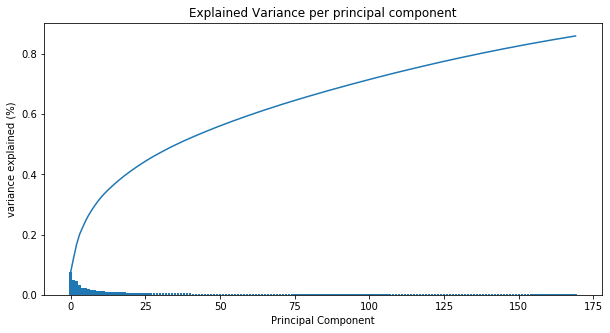

In [44]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(10,5))
x = list(range(len(standarized_data.columns)))
x = list(range(pca.n_components_))
y = variance_ratio
plt.bar(x, y, width=0.8, align='center')

accumlation = 0
acc_values = []
for i, percentage in enumerate(variance_ratio):
    accumlation += percentage
    acc_values.append(accumlation)
    #plt.annotate(str(round(percentage,2)), (i,percentage))
    
plt.xlabel('Principal Component')
plt.ylabel('variance explained (%)')
plt.title('Explained Variance per principal component')    
    
plt.plot(x, acc_values)
plt.show()

In [45]:
accumlation = 0
acc_values = []
for i, percentage in enumerate(variance_ratio):
    accumlation += percentage
    acc_values.append(accumlation)
    print(f'with {i+1} components, explained variance is: ', accumlation)

with 1 components, explained variance is:  0.07452298387943918
with 2 components, explained variance is:  0.12287925965591177
with 3 components, explained variance is:  0.1675375976408284
with 4 components, explained variance is:  0.20080909161545055
with 5 components, explained variance is:  0.2235052544966204
with 6 components, explained variance is:  0.24548357591996278
with 7 components, explained variance is:  0.26396891997638683
with 8 components, explained variance is:  0.2802625884303727
with 9 components, explained variance is:  0.2951573271608117
with 10 components, explained variance is:  0.3087683122708705
with 11 components, explained variance is:  0.3213917978762882
with 12 components, explained variance is:  0.3326574915893825
with 13 components, explained variance is:  0.3429386807267621
with 14 components, explained variance is:  0.35258627314745744
with 15 components, explained variance is:  0.36179803910744995
with 16 components, explained variance is:  0.37058802590

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 140, random_state = 0)
pca.fit(standarized_data)
variance_ratio = pca.explained_variance_ratio_
print('total variance explained by 140 components: ',sum(variance_ratio))

total variance explained by 140 components:  0.8016750506734571


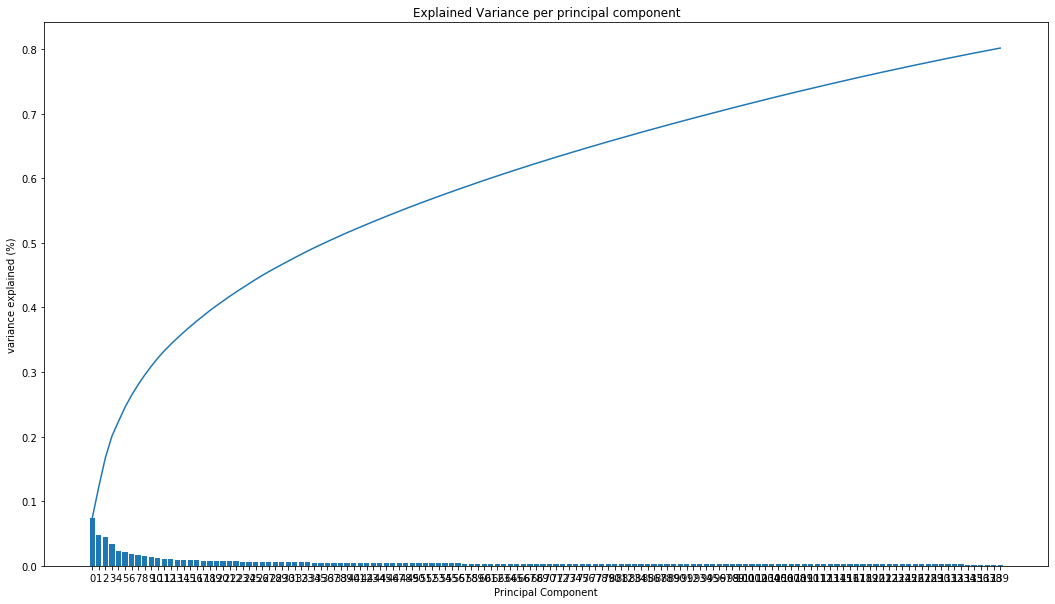

In [47]:
plt.figure(figsize=(18,10))
x = list(range(pca.n_components_))
y = variance_ratio
plt.bar(x, y, width=0.8, align='center')

accumlation = 0
acc_values = []
for i, percentage in enumerate(variance_ratio):
    accumlation += percentage
    acc_values.append(accumlation)
    #plt.annotate(str(round(percentage,2))+'%', (i,percentage), va="bottom", ha="center", fontsize = 10)
    
plt.xlabel('Principal Component')
plt.ylabel('variance explained (%)')
plt.title('Explained Variance per principal component')
plt.plot(x, acc_values)
plt.xticks(x)
plt.show()

In [48]:
reduced_data = pd.DataFrame(pca.transform(standarized_data))
reduced_data.shape

(734903, 140)

In [49]:
reduced_data.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,4.475775,5.143061,5.375063,-4.744309,0.604864,-2.522138,4.235020,0.572798,-0.652959,-0.770920,...,-1.705081,1.172339,-0.754868,-0.955051,0.396836,-0.034436,-1.006996,1.593777,-0.140741,0.323371
1,-0.860589,2.626562,1.066782,-2.797465,3.919916,-4.291211,-5.242248,-1.535202,2.077822,0.160855,...,0.558217,1.127251,0.741080,-0.260251,-0.877615,-0.487201,0.151922,-0.415185,0.495490,0.369383
2,-5.455267,0.708969,-3.800492,-3.917086,-0.611069,-1.716919,1.532026,-1.207692,-2.172070,-2.533139,...,0.741286,-0.577944,0.387241,0.138694,-0.444074,-0.686574,-0.492724,1.973204,-0.534860,0.250166
3,-2.351500,1.947003,3.594474,6.603306,-3.219062,3.390540,-2.273490,-2.623822,-0.193918,-3.645347,...,-0.899607,1.274477,0.745403,0.556914,-1.253568,-0.397798,0.360925,1.366814,-1.068877,-1.271512
4,-3.173463,1.964999,-1.178142,-3.356312,1.477085,-0.307680,0.622809,-1.690340,0.844437,-1.773769,...,-1.032985,0.996258,0.462053,-0.431130,0.439808,-0.192819,-0.953954,0.914084,-0.265728,0.149134


### Discussion 2.2: Perform Dimensionality Reduction

Generaly achieving anywhere between 80-90% of explained variance is acceptable. since we are dealing with very high dimensionality, i decided to keep enough PCA components to explain 80% of the data, meaning we need to retain 140 components.

### 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. we will use the information levels file to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- we will investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def analyze_component(component):
    lst = list(zip(standarized_data.columns, component))
    lst.sort(key=lambda tup: tup[1], reverse = True)
    
    #print(lst)
    print('first four features: ',lst[0:4],'\n')
    print('last four features: ',lst[-4:])

In [51]:
# Mapping weights for the first principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

analyze_component(pca.components_[0])

first four features:  [('PLZ8_ANTG3', 0.1415838023184833), ('KBA13_ANTG3', 0.1405904639962385), ('KBA13_ANTG4', 0.1373773559975352), ('KBA13_BAUMAX', 0.1370377061426516)] 

last four features:  [('KBA05_ANTG1', -0.13606265528435751), ('KBA13_ANTG1', -0.14214935751073515), ('PLZ8_ANTG1', -0.1428995725887383), ('MOBI_REGIO', -0.1468017256203787)]


In [52]:
# Mapping weights for the second principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

analyze_component(pca.components_[1])

first four features:  [('KBA13_HERST_BMW_BENZ', 0.18218499160198634), ('KBA13_MERCEDES', 0.155930758013584), ('KBA13_SEG_OBEREMITTELKLASSE', 0.15559220768281917), ('KBA13_BMW', 0.15178201666733254)] 

last four features:  [('KBA13_HALTER_25', -0.12081604897795702), ('KBA13_KMH_140_210', -0.12954228918235383), ('KBA13_SEG_KLEINWAGEN', -0.1296435862662352), ('KBA13_SITZE_5', -0.15007737850998268)]


In [53]:
# Mapping weights for the second principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

analyze_component(pca.components_[2])

first four features:  [('decade', 0.20483195546437075), ('CJT_TYP_1', 0.1921072145931057), ('CJT_TYP_2', 0.19037088463921756), ('FINANZ_SPARER', 0.18763694107687)] 

last four features:  [('ALTERSKATEGORIE_GROB', -0.17109075953755679), ('CJT_TYP_4', -0.17440709351678493), ('FINANZ_VORSORGER', -0.17631770324599152), ('CJT_TYP_5', -0.178446084022247)]


### Discussion 2.3: Interpret Principal Components

Before analysing the principal components there are two main points to clarify: 
- A feature having positive weight as opposed to a feature having negative weight doesn't mean that the positively weighed feature is better, it simply means that if the positively weighed feature gets a high value for a certain customer it is unlikely for the negatively weighed feature to have high value as well, and vice versa. so the data can be interpreted in more than one way due to this fact.

- After exploring the attributes file, it became apparent that many of the attributes are explained the opposit way around. for example: having a high value in the Movement patterns feature (MOBI_REGIO) would mean very low mobility. I will indicate such features with a -ve sign infront of their description written below. other features have a +ve sign infront of them.

#### Analysis of the first Principal Component

the most positively weighed features in the 1st component indicate the following:
1. PLZ8_ANTG3: number of 6-10 family houses in the PLZ8	+
2. KBA13_ANTG3: no description
3. KBA13_ANTG4: no description
4. KBA13_BAUMAX: no description

the most negatively weighed features in the 1st component indicate the following:
1. KBA05_ANTG1: number of 1-2 family houses in the cell	+
2. KBA13_ANTG1: no description
3. PLZ8_ANTG1: number of 1-2 family houses in the PLZ8	+
4. MOBI_REGIO: Moving patterns	-

##### Conclusions:

The relation between the attributes above indicate that people who own a large number number of 6-10 family houses in the PLZ8 region also tend to have a small number of 1-2 family houses in PLZ8 region as well as in the cell. they also tend to have high mobility.

#### Analysis of the second Principal Component

the most positively weighed features in the 2nd component indicate the following:
1. KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8	+
2. KBA13_MERCEDES: share of MERCEDES within the PLZ8	+
3. KBA13_SEG_OBEREMITTELKLASSE: share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)	+
4. KBA13_BMW: share of BMW within the PLZ8		+

the most negatively weighed features in the 2nd component indicate the following:
1. KBA13_HALTER_25: share of car owners between 21 and 25 within the PLZ8		+
2. KBA13_KMH_140_210: share of cars with max speed between 140 and 210 km/h within the PLZ8	+
3. KBA13_SEG_KLEINWAGEN: share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8	+
4. KBA13_SITZE_5: number of cars with 5 seats in the PLZ8 		+

##### Conclusions:

The relation between the attributes above indicate that people with a larger share of BMW and Mercedes Benz within the PLZ8 area tend to not be aged 21-25 and have a lower share of cars with max speed between 140-210 km/h, cars that are small/very small, and cars with 5 seats.


#### Analysis of the third Principal Component

the most positively weighed features in the 3rd component indicate the following:
1. decade: generation by decades	- (because a higher number means a younger generation)
2. CJT_TYP_1: no description
3. CJT_TYP_2: no description
4. FINANZ_SPARER: financial typology: money saver		-

the most negatively weighed features in the 3rd component indicate the following:
1. ALTERSKATEGORIE_GROB: age classification through prename analysis 	+
2. CJT_TYP_4: no ddescription
3. FINANZ_VORSORGER: financial typology: be prepared	-
4. CJT_TYP_5: no description

##### Conclusions:

The relation between the attributes above indicate that younger generations tend to be less concerned with saving money but are more likely to adapt a more prepared lifestyle.

## Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 3: Clustering

### 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- we will use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better.

- We will perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We can use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We should test for cluster counts through at least 10 clusters to get the full picture, but we shouldn't need to test for a number of clusters above about 30.
- Once we've selected a final number of clusters to use, we can re-fit a KMeans instance to perform the clustering operation.

In [54]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

avg_distances_lst = []
k = list(range(2,25))
for i in k:
    kmeans = KMeans(n_clusters = i).fit(reduced_data)
    avg_distance = abs(kmeans.score(reduced_data))
    avg_distance = int(avg_distance)
    avg_distances_lst.append(avg_distance)
    print(f'Average distance from centroids for {i} clusters is: ', avg_distance)

Average distance from centroids for 2 clusters is:  207905727
Average distance from centroids for 3 clusters is:  201990033
Average distance from centroids for 4 clusters is:  197193501
Average distance from centroids for 5 clusters is:  193212651
Average distance from centroids for 6 clusters is:  190177063
Average distance from centroids for 7 clusters is:  187668103
Average distance from centroids for 8 clusters is:  185698226
Average distance from centroids for 9 clusters is:  184110886
Average distance from centroids for 10 clusters is:  182765025
Average distance from centroids for 11 clusters is:  181673425
Average distance from centroids for 12 clusters is:  180652661
Average distance from centroids for 13 clusters is:  179754552
Average distance from centroids for 14 clusters is:  178900970
Average distance from centroids for 15 clusters is:  178073654
Average distance from centroids for 16 clusters is:  177350616
Average distance from centroids for 17 clusters is:  176613679


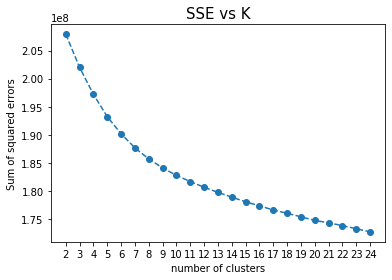

In [55]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(k, avg_distances_lst, linestyle='--', marker='o')
plt.xlabel('number of clusters')
plt.ylabel('Sum of squared errors')
plt.title('SSE vs K', fontsize = 15)
plt.xticks(k)
plt.show()    

In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 11, random_state = 0).fit(reduced_data)
general_predictions = kmeans.predict(reduced_data)

### Discussion 3.1: Apply Clustering to General Population

The SSE vs K plot shown above shows an "elbow" at clusters 7-11. after cluster number 11, the slope of the curve seems to remain somewhat constant, so I decided to go with 11 clusters.

### 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We will clean the customers data using the function created previously "clean_data", then we can use the objects we fit on the general demographics data such as the PCA object and the K-means classifier object to transform the customers dataset. We will then interpret how the general population fits apply to the customer data.

In [57]:
customers = pd.read_csv('customers.csv')
customers.drop(['Unnamed: 0', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis = 1, inplace = True)

C:\Users\Mahmo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
clean_customer_data = clean_data(customers, feat_info, dropped_columns_names, high_missing_columns)

converting missing data to np.nan...

handing unique attributes: OST_WEST_KZ and CAMEO_DEUG_2015...

handling categorical variables...

engineering the variable PRAEGENDE_JUGENDJAHRE into two new variables...

dropping columns with high number of missing values...

dropping rows with high number of missing data...

(132934, 378)


In [59]:
imputed_customer_data = pd.DataFrame(imputer.transform(clean_customer_data))
standarized_customer_data = pd.DataFrame(standarizer.fit_transform(imputed_customer_data))
reduced_customer_data = pd.DataFrame(pca.transform(standarized_customer_data))
customer_predictions = kmeans.predict(reduced_customer_data)

### 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

We will consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In the following section we will perform two things:

-we are going to visualize the ratios in cluster representations between the two groups Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html)

-using that visualization, we are going to analyze clusters that are overpresented to guide us into finding out which individuals are more likely customers, and we will also analyze underrepresented clusters to find out which individuals are unlikely to be customers for the mail order company.

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

g_pred = list(general_predictions)
c_pred = list(customer_predictions)

g_percentages = []
c_percentages = []

for i in range(0,11):
    per = g_pred.count(i)/len(g_pred)
    g_percentages.append(round(per*100,2))

for i in range(0,11):
    per = c_pred.count(i)/len(c_pred)
    c_percentages.append(round(per*100,2))

In [62]:
percentages = g_percentages.copy()
percentages.extend(c_percentages)
labels = list(range(0,11))
labels.extend(list(range(0,11)))

hue = ['general population']*11
hue.extend(['customers population']*11)

df = pd.DataFrame(list(zip(labels,percentages,hue)), columns = ['clusters','percentages','hue'])

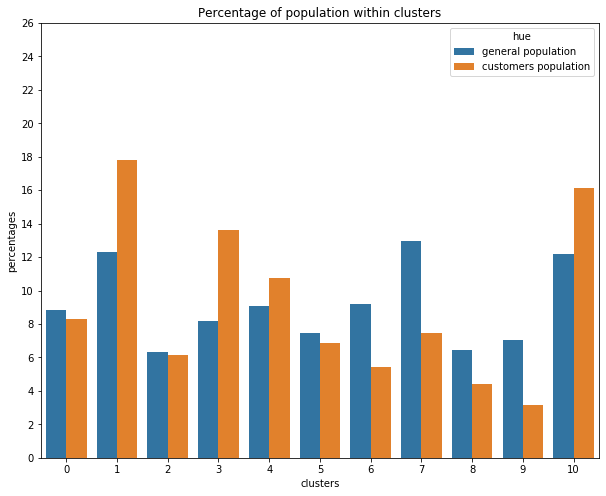

In [63]:
plt.figure(figsize=(10,8))
sns.barplot(x="clusters", y="percentages", hue="hue", data=df)
plt.yticks(list(range(0,27,2)))
plt.title("Percentage of population within clusters")
plt.show()

In [65]:
#clusters 1 and 3 are clearly overrepresented, while clusters 6 and 7 are underpresented

print('Features that represent the type of people in cluster 1: \n')
cluster_1 = pca.inverse_transform(kmeans.cluster_centers_[1])
analyze_component(cluster_1)

Features that represent the type of people in cluster 1: 

first four features:  [('FINANZ_MINIMALIST', 0.8631285335424677), ('CJT_TYP_5', 0.8293694543513409), ('FINANZ_VORSORGER', 0.813718603323718), ('CJT_TYP_3', 0.8053985990783368)] 

last four features:  [('PLZ8_ANTG3', -0.8285367741122389), ('FINANZ_SPARER', -0.8345813487228122), ('KBA13_ANTG3', -0.8430850730911814), ('CJT_TYP_2', -0.9502591630429521)]


In [66]:
print('Features that represent the type of people in cluster 3: \n')
cluster_3= pca.inverse_transform(kmeans.cluster_centers_[3])
analyze_component(cluster_3)

Features that represent the type of people in cluster 3: 

first four features:  [('GREEN_AVANTGARDE', 1.1107801022721497), ('movement', 1.1101370614215513), ('KBA13_HERST_BMW_BENZ', 1.103132785801122), ('KBA05_KW3', 1.0555817429868475)] 

last four features:  [('KKK', -0.9535225487513708), ('HH_EINKOMMEN_SCORE', -0.9565183658167988), ('KBA13_KMH_140_210', -0.9629683584131741), ('KBA13_KMH_180', -0.9736049064512348)]


In [67]:
print('Features that represent the type of people in cluster 6: \n')
cluster_6 = pca.inverse_transform(kmeans.cluster_centers_[6])
analyze_component(cluster_6)

Features that represent the type of people in cluster 6: 

first four features:  [('PLZ8_BAUMAX', 1.2378442149284474), ('KBA13_BAUMAX', 1.2367301159397548), ('KBA13_ANTG4', 1.180018777506823), ('PLZ8_ANTG4', 1.1737648763837838)] 

last four features:  [('MOBI_REGIO', -1.0331054846984928), ('KBA13_AUTOQUOTE', -1.103608241352341), ('KBA13_ANTG1', -1.1277155515286756), ('PLZ8_ANTG1', -1.137876476419717)]


In [68]:
print('Features that represent the type of people in cluster 7: \n')
cluster_7 = pca.inverse_transform(kmeans.cluster_centers_[7])
analyze_component(cluster_7)

Features that represent the type of people in cluster 7: 

first four features:  [('FINANZ_SPARER', 0.9109968029203271), ('FINANZ_UNAUFFAELLIGER', 0.9002967607955974), ('CJT_TYP_1', 0.8833063788637366), ('CJT_TYP_2', 0.8602405434505448)] 

last four features:  [('ALTERSKATEGORIE_GROB', -0.703574495151306), ('FINANZ_MINIMALIST', -0.7189482940684433), ('FINANZ_VORSORGER', -0.7815525599404675), ('CJT_TYP_5', -0.7908134185226207)]


In [69]:
#the following objects will be cleared so save some memory as they are no longer needed for the next part of the project
imputed_data = None
standarized_data = None
reduced_data = None
clean_customer_data = None
imputed_customer_data = None
standarized_customer_data = None
reduced_customer_data = None

### Discussion 3.3: Compare Customer Data to Demographics Data

same rules that were used while analyzing principal components apply here:
- A feature having positive weight as opposed to a feature having negative weight doesn't mean that the positively weighed feature is better, it simply means that if the positively weighed feature gets a high value for a certain customer it is unlikely for the negatively weighed feature to have high value as well, and vice versa. so the data can be interpreted in more than one way due to this fact.

- After exploring the attributes file, it became apparent that many of the attributes are explained the opposit way around. for example: having a high value in the Movement patterns feature (MOBI_REGIO) would mean very low mobility. I will indicate such features with a -ve sign infront of their description written below. other features have a +ve sign infront of them.


#### Cluster 1 Analysis

the most positively weighed features in cluster 1 indicate the following:
1. FINANZ_MINIMALIST: financial typology: low financial interest		-
2. CJT_TYP_5: no description
3. FINANZ_VORSORGER: financial typology: be prepared	-
4. CJT_TYP_3: no description

the most negatively weighed features in cluster 1 indicate the following:
1. PLZ8_ANTG3: number of 6-10 family houses in the PLZ8		+
2. FINANZ_SPARER: financial typology: money saver		-
3. KBA13_ANTG3: no description
4. CJT_TYP_2: no description

##### Conclusions:

The following describes a segment of the population that are likely to become customers:

individuals who have low financial interest, less likely to adapt the ideology of being prepared, own a smaller number of 6-10 family houses in the PLZ8 region, and tend to save money.

#### Cluster 3 Analysis

the most positively weighed features in cluster 3 indicate the following:

1. GREEN_AVANTGARDE: the environmental sustainability is the dominating movement in the youth of these indviduals		+
2. movement: people who adapt the Avantgarde or Mainstream ideology	(Mainstream 0 Avantgarde 1)
3. KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8	+
4. KBA05_KW3: share of cars with an engine power of more than 119 KW	+

the most negatively weighed features in cluster 3 indicate the following:

1. KKK: purchasing power	-
2. HH_EINKOMMEN_SCORE: estimated household net income 	-
3. KBA13_KMH_140_210: share of cars with max speed between 140 and 210 km/h within the PLZ8  	+
4. KBA13_KMH_180: share of cars with max speed between 110 km/h and 180km/h within the PLZ8	    +

##### Conclusions:

The following describes a segment of the population that are likely to become customers:

individuals who own a large share of BMW and Mercedes Benz within the PLZ8 region, who's dominating movement in youth is enviromental sustainability, who are Avantgarde, own cars with engine power more than 119 KW, have high estimated household net income and purchasing power and lower share of cars with max speed between 110 - 210 km/h within PLZ8 region.


#### Cluster 6 Analysis

the most positively weighed features in cluster 6 indicate the following:
1. PLZ8_BAUMAX: most common building-type within the PLZ8		+
2. KBA13_BAUMAX: no description
3. KBA13_ANTG4: no description
4. PLZ8_ANTG4: number of >10 family houses in the PLZ8		+

the most negatively weighed features in cluster 6 indicate the following:
1. MOBI_REGIO: moving patterns	-
2. KBA13_AUTOQUOTE: share of cars per household within the PLZ8		+
3. KBA13_ANTG1: no description
4. PLZ8_ANTG1: number of 1-2 family houses in the PLZ8		+

##### Conclusions:

The following describes a segment of the population that are unlikely to become customers:

individuals with most common building type in PLZ8 region being a larger home, own a larger number of >10 family houses in the PLZ8 region, who have high mobility, a lower share of cars per household and a lower number of 1-1 family hosues in the PLZ8 region.

#### Cluster 7 Analysis

the most positively weighed features in cluster 7 indicate the following:
1. FINANZ_SPARER: financial typology: money saver		-
2. FINANZ_UNAUFFAELLIGER: financial typology: unremarkable		-
3. CJT_TYP_1: no description
4. CJT_TYP_2: no description

the most negatively weighed features in cluster 7 indicate the following:
1. ALTERSKATEGORIE_GROB: age classification through prename analysis 	+
2. FINANZ_MINIMALIST: financial typology: low financial interest		-
3. FINANZ_VORSORGER: financial typology: be prepared	-
4. CJT_TYP_5: no description

##### Conclusions:

The following describes a segment of the population that are unlikely to become customers:

individuals who are less interested in saving money, who's financial typology is remarkable, who's age classification is on the younger side, have high financial interest and adapt a more prepared lifestyle.



some of the interpretations from the cluster analysis is vague and i'm not sure how the mail order company will be able to use these observations to improve their data collection and customer acquisition process, however, it is understandable that not all the observations have to be meaningful.

## 4: Supervised Learning

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 4.1 supervised learning models

The following models will be used in the supervised learning part of the project:

1. Pytorch deep learning model

we will use Pytorch to build a deep neural network and use it as a benchmark model, The reason for that is due to the cheer size of the data set, large datasets tend to boost the performance of deep learning models. should a GPU be present, which it is on the computer I’m using to execute this project, the training process will be much faster.

2. Random Forest Classifier

Random forest classifiers consists of a large number of decision trees that work as an ensemble. the decision of several decision trees is accounted for in the final decision making of the model. Random Forest can handle large datasets, and performs well in binary classification, which is the type of classification we want to do in our project. Random Forest is also resistant to overfitting and has good performance on imbalanced datasets.


3. Adaboost

Adaboost iteratively corrects the mistakes of a weak classifier and improves accuracy by combining weak learners, meaning we can select a classifier suitable for our data and boost its results. We can use a decision tree as our classifier without worrying too much about overfitting, its also applicable for continuous and categorical inputs, our data is a combination of both.

### 4.2: data preparation

In the following section, we are going to follow the following steps to prepare the data for the training of the models:

1. load the data from mailout_train.csv
2. clean the data using the previously created clean_data function
3. impute the missing and scale it
3. split the data into a training set and a validation set

In [70]:
mailout_train = pd.read_csv('mailout_train.csv')
mailout_train.drop('Unnamed: 0', axis = 1, inplace = True)
mailout_train.shape

C:\Users\Mahmo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)

In [71]:
clean_mailout_train = clean_data(mailout_train, feat_info, dropped_columns_names, high_missing_columns)
clean_mailout_train = shuffle(clean_mailout_train)

converting missing data to np.nan...

handing unique attributes: OST_WEST_KZ and CAMEO_DEUG_2015...

handling categorical variables...

engineering the variable PRAEGENDE_JUGENDJAHRE into two new variables...

dropping columns with high number of missing values...

dropping rows with high number of missing data...

(33545, 379)


In [72]:
labels = clean_mailout_train['RESPONSE']
features = clean_mailout_train.drop('RESPONSE', axis = 1)

In [73]:
imputer = SimpleImputer()
scaler = StandardScaler()

imputed_features = pd.DataFrame(imputer.fit_transform(features))
scaled_features = pd.DataFrame(scaler.fit_transform(imputed_features))

In [74]:
print(labels.value_counts(), '\n')
print(scaled_features.shape)

0    33130
1      415
Name: RESPONSE, dtype: int64 

(33545, 378)


In [75]:
x_train, x_val, y_train, y_val = train_test_split(scaled_features, 
                                                  labels, 
                                                  test_size = 0.3, 
                                                  random_state = 0,
                                                  stratify = labels)

print(y_train.value_counts(), '\n')
print(y_val.value_counts())

0    23191
1      290
Name: RESPONSE, dtype: int64 

0    9939
1     125
Name: RESPONSE, dtype: int64


### 4.3: Model Specifications and Training

#### 4.3.1: Pytorch Model

two files were imported as they contain the code for the pytorch modeL: pytorch_model and model.utils:

1. pytorch_model.py: this file contains the model class. it defines the hidden layers, activation functions and forward method.

2. model.utils: this file contains two methods, one for training the model and one for visualizing the evaluations of the model that happened during the training process

The model contains two hidden layers. the first hidden layer contains 200 nodes, the second hidden layer contains 50 nodes, and the output layer contains a single node as this is a binary classification problem. 

each hidden layer is passed to a relu activation function and is batch normalized before entering the next layer inorder to speed up the training of the neural network. 

- dropout with value p = 0.5 is used to help against the model overfitting.

- The criterion for the model is BCEWithLogitsLoss. BCEloss is a criterion that measures the Binary Cross Entropy between the target and the output, BCEWithLogitsLoss however combines a Sigmoid layer and the BCELoss in one single class. according to Pytorch documentation, This version is more numerically stable than using a plain Sigmoid followed by a BCELoss.

- The optimizer for the model is Adam.
- Learning rate for the model was set to 0.005

in the following section, we will define a class that holds the training and validation data and passes them to a dataloader for the training process of the deep learning model. the reason for using a dataloader is that is working with large datasets requires loading them into memory all at once. This leads to memory outage and slowing down of programs. PyTorch offers a solution for parallelizing the data loading process with the support of automatic batching.

In [76]:
#This class is created to pass the data to the Dataloader object
class Data_for_loader(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [77]:
train_data = Data_for_loader(torch.FloatTensor(x_train.values), 
                             torch.FloatTensor(y_train.values))

test_data = Data_for_loader(torch.FloatTensor(x_val.values),
                            torch.FloatTensor(y_val.values))

train_loader = DataLoader(dataset = train_data, shuffle= True, batch_size = 150)
validation_loader = DataLoader(dataset=test_data, batch_size= 150)

Now that the data is prepared for training, we are going to fit the models to our data and measure their performace using ROC AUC score.

In [78]:
model = BinaryClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

BinaryClassifier(
  (h1): Linear(in_features=378, out_features=200, bias=True)
  (h2): Linear(in_features=200, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


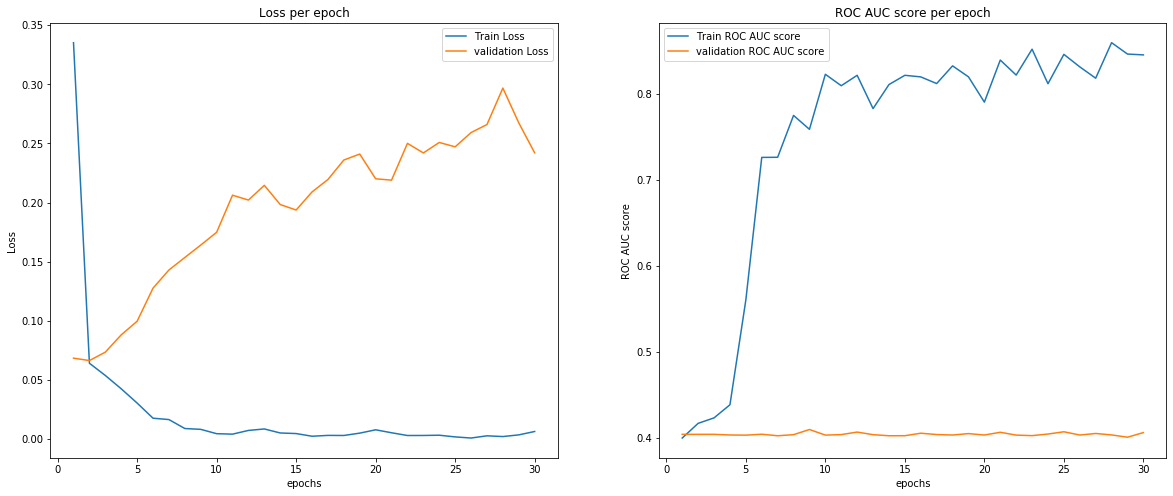

In [79]:
results = train_model(model, train_loader, validation_loader)
visualize_results(results)

#### 4.3.2: Random Forest model specifications

The following hyperparameters will be tuned to improve the performance of the random forest classifier:

1. n_estimators: The number of trees in the forest.
2. max_depth: The maximum depth of the tree.
3. min_samples_split: The minimum number of samples required to split an internal node.
4. min_samples_leaf: The minimum number of samples required to be at a leaf node.
5. max_features: The number of features to consider when looking for the best split.
6. class_weight: Weights associated with classes in the form {class_label: weight}

#### 4.3.3: Adaboost model specifications

The base estimator for the Adaboost algorithm will be Decision Tree.

The following hyperparameters will be tuned to improve the performance of the Adaboost classifier:

1. n_estimators: The maximum number of estimators at which boosting is terminated.
2. learning_rate: Learning rate shrinks the contribution of each estimator by learning_rate. There is a trade-off between learning_rate and n_estimators.


#### Hyperparameter Tuning

inorder to find the best hyperparameters for each model, we will use RandomizedSearchCV, which is a tool provided by sklearn to fit the model with a different range of hyperparameters and comparing them along the way to reach the best classifier for these hyperparameter ranges. unlike Gridsearch, which tests every single hyperparameter combination, RandomizedSearch fits the model with a random combinations of the hyperparameters inorder to find an optimized classifier much faster.

In [80]:
#hyperparameter tuning method that takes in a classifier and a dicitonary of the hyperparameters 
#to return the best classifier

def find_best_parameters(clf, hyperparameters, x_train, y_train):
    scorer = make_scorer(roc_auc_score)
    randomized_searcher = RandomizedSearchCV(estimator = clf, param_distributions = hyperparameters, n_iter = 50, 
                                             cv = 3, random_state= 0, n_jobs = -2, scoring = scorer)
    
    randomized_searcher.fit(x_train, y_train)
    print('best hyperparameter values: \n', randomized_searcher.best_params_)
    
    return randomized_searcher.best_estimator_

In [81]:
#hyperparameters for random forest

rf_n_estimators = [10, 50, 100]
max_depth = [3, 5, 10]
min_samples_split = [3, 5, 7]
min_samples_leaf = [3, 4, 5]
max_features = ['auto', 'sqrt']
class_weight = ['balanced', 'balanced_subsample']

rf_hyperparameters = {'n_estimators': rf_n_estimators,
                      'max_features': max_features,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,
                      'class_weight': class_weight}

In [82]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf = find_best_parameters(rf_clf, rf_hyperparameters, x_train, y_train)

y_pred = rf_clf.predict(x_val)

print('\nroc score: ', roc_auc_score(y_val, y_pred))

best hyperparameter values: 
 {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3, 'class_weight': 'balanced_subsample'}

roc score:  0.6212021330113695


In [83]:
#hyperparameters for Adaboost

ada_n_estimators = [30, 50, 100]
learning_rate = [0.7, 1, 1.3]

adaboost_hyperparameters = {'n_estimators': ada_n_estimators,
                            'learning_rate': learning_rate}

In [84]:
ada_clf = AdaBoostClassifier(random_state = 0)
ada_clf = find_best_parameters(ada_clf, adaboost_hyperparameters, x_train, y_train)

y_pred = ada_clf.predict(x_val)

print('\nroc score: ', roc_auc_score(y_val, y_pred))

C:\Users\Mahmo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


best hyperparameter values: 
 {'n_estimators': 100, 'learning_rate': 1.3}

roc score:  0.49929570379313815


In [85]:
#to check if the adaboost model trained at all ill predict the values in the x_train and compare the predictions to y_train
y_pred = ada_clf.predict(x_train)

print('roc score: ', roc_auc_score(y_train, y_pred))

roc score:  0.5029955140148006


### 4.4: Model Refinement

#### 4.4.1: Analysing Results after first iteration

looking at the model evaluation graph for the pytorch model, and ROC AUC scores of the adaboost model, it looks like pytorch model is overfitting while the adaboost model didn't train properly.

One reason for this could be due to the severe class imbalance, the number of negative samples is 80 times the number of positive samples. Random Forest Classifier wasn't affected by this due to the parameter 'class weights' built in the model, which allows the model to automatically adjust weights inversely proportional to class frequencies.

one method that we can utilize to handle class imbalance is Random Oversampling, which generates new samples by randomly sampling and replacing the current available samples.

for the pytorch model, I will utilize the builtin argument in the loss function called 'pos_weight' which allows us to assign a weight to positive samples in a binary classification problem, this value will be compared to value 1 for negative samples. this change will be applied by changing the argument 'balance_weights' in the train_model function in model.utils file to True.

since the number of negative samples are 80 times more than the number of positive samples, weight of value 80 will be given to the pos_weight argument.

In [86]:
ros = RandomOverSampler(random_state=0)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

In [87]:
model = BinaryClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BinaryClassifier(
  (h1): Linear(in_features=378, out_features=200, bias=True)
  (h2): Linear(in_features=200, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

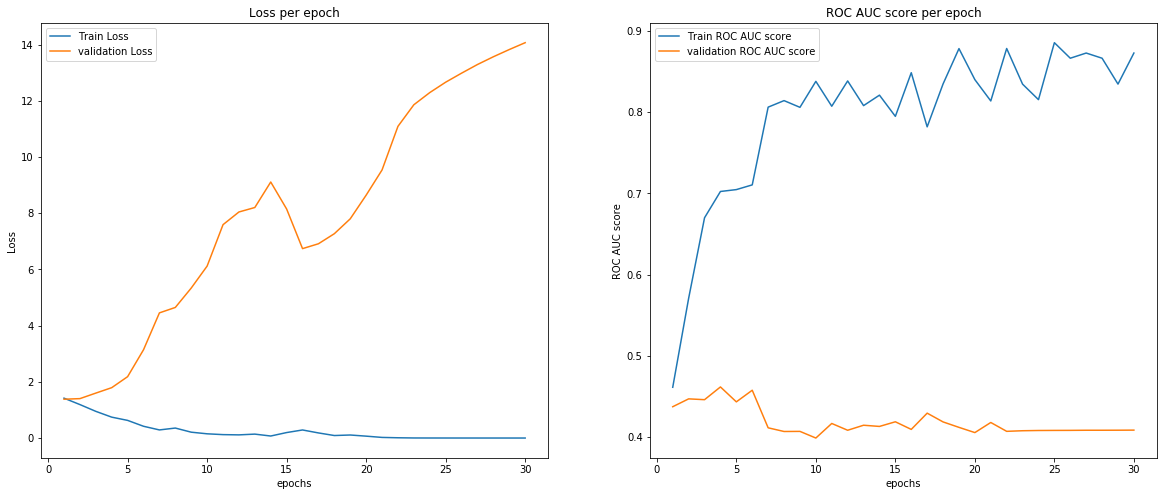

In [88]:
results = train_model(model, train_loader, validation_loader, balance_weights = True)
visualize_results(results)

In [89]:
ada_clf = AdaBoostClassifier(random_state = 0)
ada_clf = find_best_parameters(ada_clf, adaboost_hyperparameters, x_train_resampled, y_train_resampled)

y_pred = ada_clf.predict(x_val)

print('\nroc score: ', roc_auc_score(y_val, y_pred))

C:\Users\Mahmo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


best hyperparameter values: 
 {'n_estimators': 100, 'learning_rate': 1.3}

roc score:  0.5838390180098602


In [90]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf = find_best_parameters(rf_clf, rf_hyperparameters, x_train_resampled, y_train_resampled)

y_pred = rf_clf.predict(x_val)

print('\nroc score: ', roc_auc_score(y_val, y_pred))

best hyperparameter values: 
 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'class_weight': 'balanced'}

roc score:  0.5200281718482744


#### 4.4.2: Analysing Results after second iteration

After dealing with the issue of class imbalance, The performances the adaboost model improved from random chance to achieving 0.59, and the pytorch model seems to still overfit but a bit slower than before. the Random Forest Classifier was negatively impacted by this change due to the fact that it already accounted for class imbalance using the 'class_weight' argument.

one other reason that could be negatively impacting the performance of our models is the dataset itself, since we imputed the missing data with the means, there is a possibility that this is negatively impacting our model. in the following part, we will remove all rows containing missing data for all negative samples.

In [91]:
#in this cell we will remove any rows containing missing data
clean_mailout_train.reset_index(inplace = True, drop = True)
row_missings = clean_mailout_train.isna().sum(axis = 1)

missing_rows = []

for ind,missings in enumerate(row_missings):
    if missings>0:
        missing_rows.append(ind)


clean_mailout_train2 = clean_mailout_train.drop(missing_rows, axis = 0)
print(clean_mailout_train2.shape)

(27092, 379)


In [92]:
labels2 = clean_mailout_train2['RESPONSE']
features2 = clean_mailout_train2.drop('RESPONSE', axis = 1)

In [93]:
imputed_features2 = pd.DataFrame(imputer.fit_transform(features2))
scaled_features2 = pd.DataFrame(scaler.fit_transform(imputed_features2))

In [94]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(scaled_features2, 
                                                      labels2, 
                                                      test_size = 0.3, 
                                                      random_state = 0,
                                                      stratify = labels2)

In [95]:
#this cell utilizes random over sampling for adaboost model since it showed improvement previously using this method
ros = RandomOverSampler(random_state=0)
x_train_resampled2, y_train_resampled2 = ros.fit_resample(x_train2, y_train2)

In [96]:
train_data = Data_for_loader(torch.FloatTensor(x_train2.values), 
                             torch.FloatTensor(y_train2.values))

test_data = Data_for_loader(torch.FloatTensor(x_val2.values),
                            torch.FloatTensor(y_val2.values))

train_loader = DataLoader(dataset = train_data, shuffle= True, batch_size = 150)
validation_loader = DataLoader(dataset = test_data, batch_size= 150)

In [97]:
model = BinaryClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BinaryClassifier(
  (h1): Linear(in_features=378, out_features=200, bias=True)
  (h2): Linear(in_features=200, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

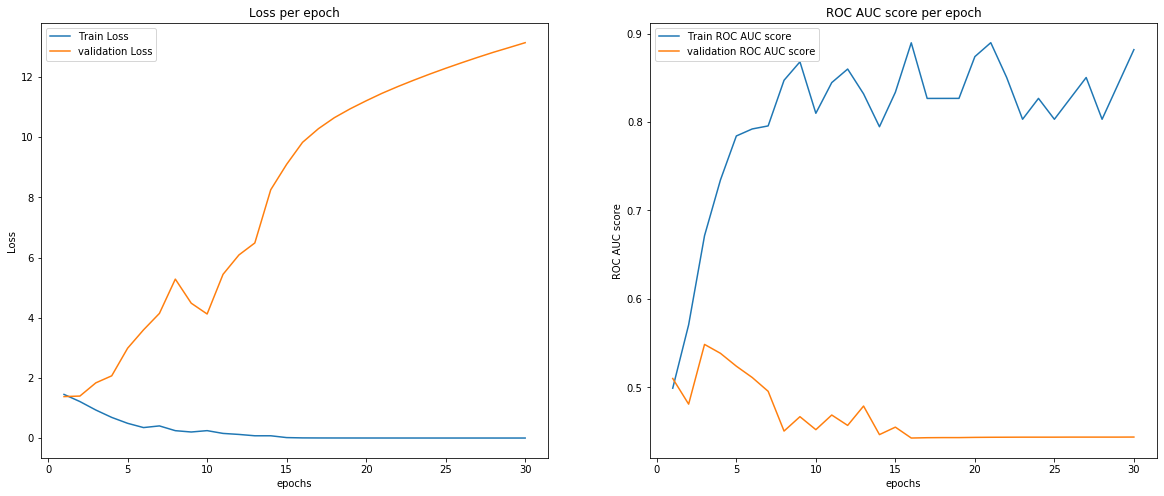

In [98]:
results = train_model(model, train_loader, validation_loader, balance_weights = True)
visualize_results(results)

In [99]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf = find_best_parameters(rf_clf, rf_hyperparameters, x_train2, y_train2)

y_pred = rf_clf.predict(x_val)

print('\nroc score: ', roc_auc_score(y_val, y_pred))

best hyperparameter values: 
 {'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 3, 'class_weight': 'balanced'}

roc score:  0.7006181708421371


In [101]:
ada_clf = AdaBoostClassifier(random_state = 0)
ada_clf = find_best_parameters(ada_clf, adaboost_hyperparameters, x_train_resampled2, y_train_resampled2)

y_pred = ada_clf.predict(x_val2)

print('\nroc score: ', roc_auc_score(y_val2, y_pred))

C:\Users\Mahmo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


best hyperparameter values: 
 {'n_estimators': 100, 'learning_rate': 1}

roc score:  0.549711442595291


### 4.5: Final Model

After removing rows with missing data instead of imputing them with the mean, Random Forest is showing a lot of improvement as it reached a score of 0.7. adaboost performance degraded and pytorch doesn't performance doesn't seem to be affected by this change.

Random Forest Classifier will be used as our final model for our predictions on the test file in the following section.

## 5: Reflection

In order to achieve our final Random Forest Classifier, the data has to be prepared as follows:

1. missing information must be removed from the data 
2. several categorical variables need to be one hot encoded and several categorical variables must be dropped as they could potentially double or even tripple the size of the data if they were one hot encoded.
3. certain Mixed-type variables need to be re-engineered
4. data needs to be scaled using a standard scaler

once the data is prepared the Random Forest classifier must be fit to the training data, class imbalance must be accounted for using the 'class_weight' argument in the Classifier. 

to be able to determine the best hyperparameters for the classifier, GridSearch or RandomizedSearch need to be utilized to find the best hyperparameters within a certain hyperparameter range.

after finding the best hyperparameters, the model can be used to make predictions on the mailout test file.

This project was a great opportunity to expand my knowledge regarding testing different approaches to improve the performance of a machine learning model. in particular, i enjoyed reasearching about methods to deal with class imbalance.

## 6: Improvement

The following points can be investigated to improve the performance of our model

1. during the training process, several categorical variables have been removed instead of being one hot encoded, some of these variables could have been valuable for the training process, however, it would have increased the data size making the process more computationaly expensive.

2. Further investigation into dealing with the missing data, instead of imputing them with the mean or removing them, a different imputation value other than the mean could be tested.

3. we used a standardscaler to scale our data, a different scaler could be tested, such as such as minmax scaler as it preserves the shape of the original data distribution, and is less disruptive to the information in the original data.

4. Further changes can be tested on the pytorch model, such as changing the hidden layers or using a different optimizer.